# 0. malaria 

## 이미지 출처 
* [LHNCBC Full Download List](https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets)
* [Malaria Cell Images Dataset | Kaggle](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria)
* 관련 논문 : [Performance evaluation of deep neural ensembles toward malaria parasite detection in thin-blood smear images [PeerJ]](https://peerj.com/articles/6977/)
* 관련 논문 github: [Deep-Neural-Ensembles-toward-Malaria-Parasite-Detection-in-Thin-Blood-Smear-Images](https://github.com/sivaramakrishnan-rajaraman/Deep-Neural-Ensembles-toward-Malaria-Parasite-Detection-in-Thin-Blood-Smear-Images)

## 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd

## 이미지 다운로드

In [2]:
# 이미지 다운로드
!wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

--2023-02-21 12:48:36--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 52.222.139.96, 52.222.139.89, 52.222.139.91, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|52.222.139.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip.2’

cell_images.zip.2   100%[===================>] 337.08M  17.0MB/s    in 24s     

2023-02-21 12:49:00 (14.3 MB/s) - ‘cell_images.zip.2’ saved [353452851/353452851]



In [3]:
# 파일 압축 해제하기
!unzip cell_images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_91.

In [4]:
import os
for root, dirs, files in os.walk("./cell_images/"):
    print(root, dirs, len(files))

./cell_images/ ['Parasitized', 'Uninfected'] 0
./cell_images/Parasitized [] 13780
./cell_images/Uninfected [] 13780


#1. 데이터셋

In [5]:
import glob
upics = glob.glob('./cell_images/Uninfected/*.png')
apics = glob.glob('./cell_images/Parasitized/*.png')
len(upics), upics[0], len(apics), apics[0]

(13779,
 './cell_images/Uninfected/C232ThinF_IMG_20151112_154211_cell_134.png',
 13779,
 './cell_images/Parasitized/C175P136NThinF_IMG_20151127_142326_cell_231.png')

## matplotlib

In [6]:
import matplotlib.pyplot as plt

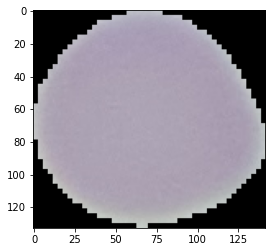

In [7]:
upics_0 = upics[0]
upics_0_img = plt.imread(upics_0)
plt.imshow(upics_0_img)

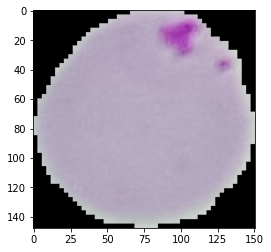

In [8]:
apics_0 = apics[0]
apics_0_img = plt.imread(apics_0)
plt.imshow(apics_0_img)

## cv2

In [9]:
import cv2

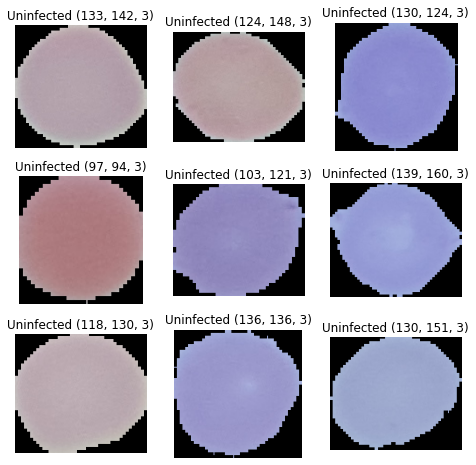

In [10]:
plt.figure(figsize=(8, 8))
labels = "Uninfected"
for i, images in enumerate(upics[:9]):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(images)
    plt.imshow(img)
    plt.title(f'{labels} {img.shape}')
    plt.axis("off")

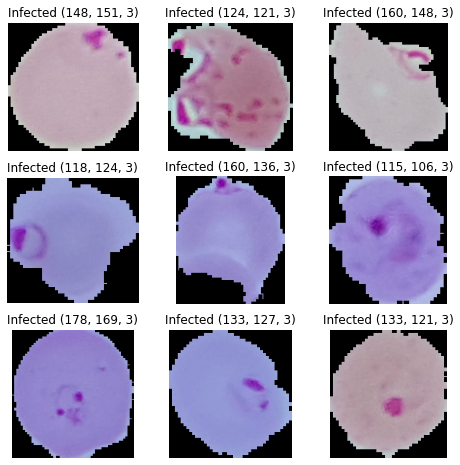

In [11]:
plt.figure(figsize=(8, 8))
labels = "Infected"
for i, images in enumerate(apics[:9]):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(images)
    plt.imshow(img)
    plt.title(f'{labels} {img.shape}')
    plt.axis("off")

## 데이터셋 전처리

In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)
datagen

In [14]:
# 이미지의 사이즈가 불규칙하면 학습을 할 수 없기 때문에 리사이즈할 크기를 지정합니다.
width = 32
height = 32

In [15]:
# 학습 데이터
trainDatagen = datagen.flow_from_directory(directory = 'cell_images/',
                                           target_size = (height, width),
                                           class_mode = 'binary',
                                           batch_size = 64,
                                           subset='training')

Found 22048 images belonging to 2 classes.


In [16]:
# 검증 데이터
valDatagen = datagen.flow_from_directory(directory = 'cell_images/',
                                         target_size =(height, width),
                                         class_mode = 'binary',
                                         batch_size = 64,
                                         subset='validation')

Found 5510 images belonging to 2 classes.


# 2. 기본 CNN

In [17]:
model = Sequential()

# 입력층
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='valid',
                 activation='relu', input_shape=(height, width, 3)))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=1))


model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=1))

# 오버피팅 방지
model.add(Dropout(0.2))

# Fully-connected layer
model.add(Flatten())
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=32, activation="relu"))

# 출력층=> binary classification
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                    

In [19]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics="accuracy"
)

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [21]:
history = model.fit(trainDatagen, epochs=100, 
                    callbacks=early_stop, validation_data=valDatagen)

Epoch 1/100
345/345 [==============================] - 40s 96ms/step - loss: 0.4058 - accuracy: 0.7965 - val_loss: 0.1905 - val_accuracy: 0.9314
Epoch 2/100
345/345 [==============================] - 31s 89ms/step - loss: 0.1587 - accuracy: 0.9487 - val_loss: 0.1696 - val_accuracy: 0.9410
Epoch 3/100
345/345 [==============================] - 31s 90ms/step - loss: 0.1392 - accuracy: 0.9551 - val_loss: 0.1454 - val_accuracy: 0.9459
Epoch 4/100
345/345 [==============================] - 30s 88ms/step - loss: 0.1301 - accuracy: 0.9569 - val_loss: 0.1523 - val_accuracy: 0.9450
Epoch 5/100
345/345 [==============================] - 30s 88ms/step - loss: 0.1198 - accuracy: 0.9601 - val_loss: 0.1488 - val_accuracy: 0.9459
Epoch 6/100
345/345 [==============================] - 31s 91ms/step - loss: 0.1124 - accuracy: 0.9617 - val_loss: 0.1675 - val_accuracy: 0.9439
Epoch 7/100
345/345 [==============================] - 31s 89ms/step - loss: 0.1048 - accuracy: 0.9648 - val_loss: 0.1570 - val_ac

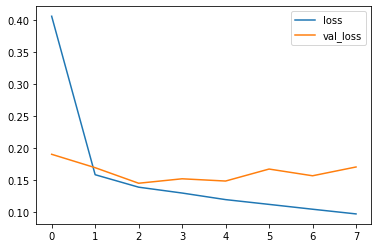

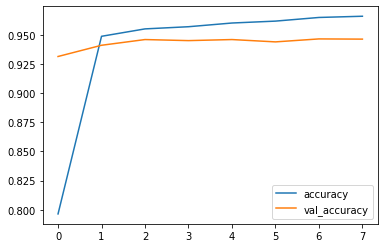

In [22]:
df_hist = pd.DataFrame(history.history)
df_hist[["loss", "val_loss"]].plot()
df_hist[["accuracy", "val_accuracy"]].plot()

# 3. VGG16

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(weights="imagenet", 
            include_top=False, 
            input_shape=(width, height, 3))

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

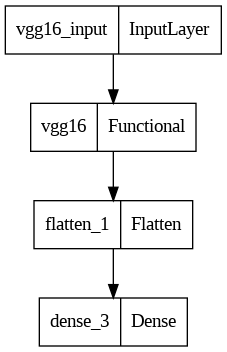

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [25]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [26]:
history = model.fit(trainDatagen,
                    epochs = 100,
                    validation_data = valDatagen,
                    callbacks=[early_stop])

Epoch 1/100
345/345 [==============================] - 41s 101ms/step - loss: 0.4947 - accuracy: 0.7070 - val_loss: 0.1678 - val_accuracy: 0.9358
Epoch 2/100
345/345 [==============================] - 38s 110ms/step - loss: 0.1483 - accuracy: 0.9552 - val_loss: 0.1517 - val_accuracy: 0.9515
Epoch 3/100
345/345 [==============================] - 35s 101ms/step - loss: 0.1319 - accuracy: 0.9594 - val_loss: 0.1492 - val_accuracy: 0.9535
Epoch 4/100
345/345 [==============================] - 33s 96ms/step - loss: 0.1189 - accuracy: 0.9623 - val_loss: 0.1557 - val_accuracy: 0.9521
Epoch 5/100
345/345 [==============================] - 34s 97ms/step - loss: 0.1222 - accuracy: 0.9616 - val_loss: 0.1330 - val_accuracy: 0.9534
Epoch 6/100
345/345 [==============================] - 33s 95ms/step - loss: 0.1218 - accuracy: 0.9596 - val_loss: 0.1413 - val_accuracy: 0.9544
Epoch 7/100
345/345 [==============================] - 34s 99ms/step - loss: 0.1106 - accuracy: 0.9633 - val_loss: 0.1278 - val

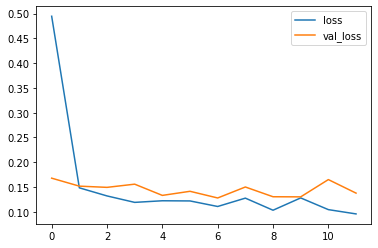

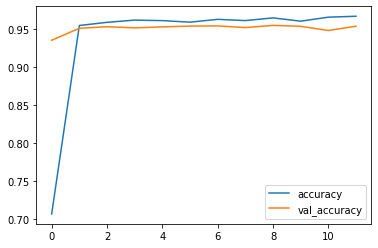

In [27]:
df_hist = pd.DataFrame(history.history)
df_hist[["loss", "val_loss"]].plot()
df_hist[["accuracy", "val_accuracy"]].plot()